In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import ast
from advisor_client.client import *
client = AdvisorClient()

In [2]:
# get study
study_name = "optimal_jump1"
study = client.get_study_by_name(study_name)
print(study)

Id: 1, name: optimal_jump1, study_configuration: {"randomInitTrials": 20, "params": [{"parameterName": "jump_a", "type": "DOUBLE", "maxValue": 5.0, "minValue": -5.0}, {"parameterName": "jump_b", "type": "DOUBLE", "maxValue": 5.0, "minValue": -5.0}, {"parameterName": "jump_c", "type": "DOUBLE", "maxValue": 5.0, "minValue": -5.0}, {"parameterName": "jump_d", "type": "DOUBLE", "maxValue": 3.5, "minValue": 0}, {"parameterName": "opt_vel", "type": "DOUBLE", "maxValue": 6.0, "minValue": 2.0}], "goal": "MINIMIZE"}, algorithm: BayesianOptimization


In [28]:
# plot training Loss vs Epoch
train_curve = []
train_param = []
trials = client.list_trials(study_name)

for trial in trials:
    trial_metrics = client.list_trial_metrics(study_name,trial.id)
    train_param.append(ast.literal_eval(trial.parameter_values)) # string to dictionary
    for metrics in trial_metrics:
        train_curve.append(metrics.objective_value)

for param,objval in zip(train_param,train_curve):
    param["objective_value"] = objval

train_curve = np.array(train_curve)

In [4]:
save_fig = False

Is study done: True
Best epoch: 99
Best trial: Id: 100, study_name: optimal_jump1, name: BayesianOptimizationTrial, parameter_values: {"opt_vel": 2.4510971061471922, "jump_d": 2.5745559244854648, "jump_c": 3.3526312914223073, "jump_b": -3.6767745778012206, "jump_a": 0.31170989649604763}, objective_value: 9.95308138004


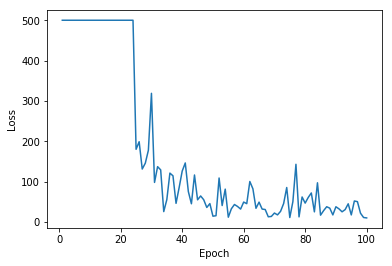

In [5]:
scale = 500
train_curve_clip = np.clip(train_curve,0,scale)
best_trial = client.get_best_trial(study_name)
best_objval = round(best_trial.objective_value,3)
print("Is study done: %r"%client.is_study_done(study_name))
print("Best epoch: %d"%np.argmin(train_curve))
print("Best trial: {}".format(best_trial))

plt.plot(range(1,len(train_curve)+1),train_curve_clip)
plt.xlabel("Epoch")
plt.ylabel("Loss")
if save_fig:
    plt.savefig("./records/loss_"+str(best_objval)+"_"+str(scale)+".png")
plt.show()

max objval: 16.780
{'opt_vel': 2.4510971061471922, 'objective_value': 9.95308138004, 'jump_d': 2.5745559244854648, 'jump_c': 3.3526312914223073, 'jump_b': -3.6767745778012206, 'jump_a': 0.31170989649604763}
{'opt_vel': 2.4341007574959588, 'objective_value': 10.9068976337, 'jump_d': 3.406124917209566, 'jump_c': 3.0482766793789864, 'jump_b': -4.685607386463603, 'jump_a': 0.31403372165573185}
{'opt_vel': 2.458242178310357, 'objective_value': 10.969862828, 'jump_d': 3.4533539637775137, 'jump_c': 3.095761034240411, 'jump_b': -4.7158785219995645, 'jump_a': 0.33033237126736115}
{'opt_vel': 2.434279654305911, 'objective_value': 11.7253827322, 'jump_d': 2.486106348585756, 'jump_c': 3.031374653984386, 'jump_b': -3.790678230704766, 'jump_a': 0.2030486185691771}
{'opt_vel': 2.445952732936544, 'objective_value': 12.5227352739, 'jump_d': 3.340561414314088, 'jump_c': 3.1764425837661427, 'jump_b': -4.568821611582541, 'jump_a': 0.07458238639392256}
{'opt_vel': 2.3962579700967073, 'objective_value': 12.

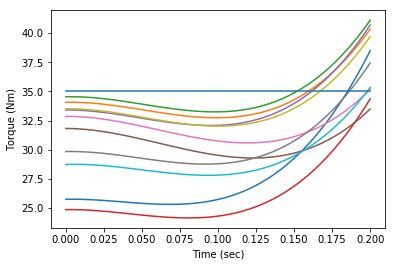

In [8]:
topk_idx = np.argsort(train_curve)[:10] # sort top n minimial index
print("max objval: %.3f"%np.max(train_curve[topk_idx]))
t = np.linspace(0,0.2,100)
y_constant = 35*np.ones_like(t)
for idx in topk_idx:
    param = train_param[idx]
    print(param)
    a = param["jump_a"]
    b = param["jump_b"]
    c = param["jump_c"]
    d = param["jump_d"]
    y_poly = 10*a * t + 100*b * t**2 + 1000*c * t**3 + 10*d
    plt.plot(t,y_poly)
plt.plot(t,y_constant)
plt.xlabel("Time (sec)")
plt.ylabel("Torque (Nm)")
if save_fig:
    plt.savefig("./records/torque_"+str(best_objval)+".png")
plt.show()

In [22]:
# display top n trials in webots
top_n = 5
for count,idx in zip(range(top_n),topk_idx[:top_n]):
    param_dic = train_param[idx]
    # print(param_dic)
    with open("./controllers/my_controller_python/args.txt",'w') as f1:
        f1.write(str(param_dic))

    os.system("webots --mode=pause")

    with open("./controllers/my_controller_python/metrics.txt",'r') as f2:
        metrics_dic = eval(f2.read())
        y = metrics_dic["jump_metrics"]
        
    print("top %d, real_obj: %.3f, train_obj: %.3f"%(count,y,param_dic["objective_value"]))

top 0, real_obj: 14.154, train_obj: 9.953
top 1, real_obj: 14.154, train_obj: 10.907
top 2, real_obj: 14.154, train_obj: 10.970
top 3, real_obj: 14.154, train_obj: 11.725
top 4, real_obj: 14.154, train_obj: 12.523


In [31]:
# save dicts to txt
with open("./records/args_"+str(best_objval)+".txt",'w') as arts_txt:
    for param_dict in train_param:
        arts_txt.write(str(param_dict)+"\n") # one dictionary per line

In [23]:
# save dicts to csv
import csv
with open("./records/args_"+str(best_objval)+".csv",'w') as args_csv:
    w = csv.DictWriter(args_csv,train_param[0].keys())
    w.writeheader()
    for param_dict in train_param:
        w.writerow(param_dict)

In [32]:
# read from txt
train_param = []
with open("./records/args_9.953.txt",'r') as arts_txt:
    lines = arts_txt.readlines()
    for line in lines:
        train_param.append(eval(line))